# Distinguish Your Own Digits (DYOD)

You are going to write a classifier that distinguishes between the number 3 and number 8.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

From the command line run `pip install mnist`. This is a library that will help you bring down the mnist dataset. If you run this from a notebook, you need to put  `!pip install mnist` in a cell by itself.

In [3]:
!pip install mnist

## Preparing the Data

In [4]:
import mnist

In [5]:
train_images = mnist.train_images()
train_labels = mnist.train_labels()

In [6]:
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

In [7]:
test_images = mnist.test_images()
test_labels = mnist.test_labels()

In [8]:
test_images.shape, test_labels.shape

((10000, 28, 28), (10000,))

2


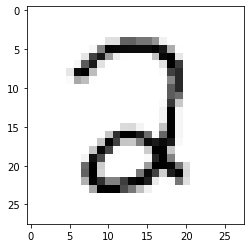

In [9]:
image_index = 7776 # You may select anything up to 60,000
print(train_labels[image_index]) 
plt.imshow(train_images[image_index], cmap='Greys')

## Filter data to get 3 and 8 out

In [10]:
train_filter = np.where((train_labels == 3 ) | (train_labels == 8))
test_filter = np.where((test_labels == 3) | (test_labels == 8))
X_train, y_train = train_images[train_filter], train_labels[train_filter]
X_test, y_test = test_images[test_filter], test_labels[test_filter]

We normalize the pizel values in the 0 to 1 range

In [11]:
X_train = X_train/255.
X_test = X_test/255.

And setup the labels as 1 (when the digit is 3) and 0 (when the digit is 8)

In [12]:
y_train = 1*(y_train==3)
y_test = 1*(y_test==3)

In [13]:
X_train.shape, X_test.shape

((11982, 28, 28), (1984, 28, 28))

We reshape the data to flatten the image pixels into a set of features or co-variates:

In [14]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train.shape, X_test.shape

((11982, 784), (1984, 784))

In [15]:
#Impoting functions from 'Kudzu'
from kudzu.model import Model
from kudzu.train import Learner
from kudzu.optim import GD
from kudzu.data import Data, Sampler,Dataloader

from kudzu.callbacks import AccCallback
from kudzu.callbacks import ClfCallback

from kudzu.loss import MSE

from kudzu.layer import Sigmoid,Relu
from kudzu.layer import Affine

### Let us create a `Config` class, to store important parameters. 
This class essentially plays the role of a dictionary.

In [16]:
class Config:
    pass
config = Config()
config.lr = 0.001
config.num_epochs = 250
config.bs = 50

### Running Models with the Training data
Details about the network layers:
- A first affine layer has 784 inputs and does 100 affine transforms. These are followed by a Relu
- A second affine layer has 100 inputs from the 100 activations of the past layer, and does 100 affine transforms. These are followed by a Relu
- A third affine layer has 100 activations and does 2 affine transformations to create an embedding for visualization. There is no non-linearity here.
- A final "logistic regression" which has an affine transform from 2 inputs to 1 output, which is squeezed through a sigmoid.


In [17]:
data = Data(X_train, y_train.reshape(-1,1))
sampler = Sampler(data, config.bs, shuffle=True)

dl = Dataloader(data, sampler)

opt = GD(config.lr)
loss = MSE()

In [18]:
training_data_x = X_train
testing_data_x = X_test
training_data_y = y_train.reshape(-1,1)
testing_data_y = y_test.reshape(-1,1)

In [19]:
layers = [Affine("first", 784, 100), Relu("first"), Affine("second", 100, 100), Relu("second"), Affine("third", 100, 2), Affine("last", 2, 1), Sigmoid("last")]
model_nn = Model(layers)
model_lr = Model([Affine("logits", 784, 1), Sigmoid("sigmoid")])

xavier
xavier
xavier
xavier
xavier


In [20]:
nn_learner = Learner(loss, model_nn, opt, config.num_epochs)
acc_nn = ClfCallback(nn_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
nn_learner.set_callbacks([acc_nn])

In [21]:
lr_learner = Learner(loss, model_lr, opt, config.num_epochs)
acc_lr = ClfCallback(lr_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
lr_learner.set_callbacks([acc_lr])

In [22]:
nn_learner.train_loop(dl)

Epoch 0, Loss 0.229
Training Accuracy: 0.7693, Testing Accuracy: 0.7848



Epoch 10, Loss 0.0634
Training Accuracy: 0.9367, Testing Accuracy: 0.9441



Epoch 20, Loss 0.0442
Training Accuracy: 0.9524, Testing Accuracy: 0.9541



Epoch 30, Loss 0.0367
Training Accuracy: 0.9594, Testing Accuracy: 0.9622



Epoch 40, Loss 0.0326
Training Accuracy: 0.9634, Testing Accuracy: 0.9662



Epoch 50, Loss 0.0299
Training Accuracy: 0.9662, Testing Accuracy: 0.9677



Epoch 60, Loss 0.028
Training Accuracy: 0.9686, Testing Accuracy: 0.9688



Epoch 70, Loss 0.0265
Training Accuracy: 0.9710, Testing Accuracy: 0.9688



Epoch 80, Loss 0.0252
Training Accuracy: 0.9726, Testing Accuracy: 0.9703



Epoch 90, Loss 0.0241
Training Accuracy: 0.9739, Testing Accuracy: 0.9713



Epoch 100, Loss 0.0232
Training Accuracy: 0.9745, Testing Accuracy: 0.9728



Epoch 110, Loss 0.0224
Training Accuracy: 0.9752, Testing Accuracy: 0.9723



Epoch 120, Loss 0.0217
Training Accuracy: 0.9760, Testing Accuracy: 0.9728



Epoch 130, Loss 0.021
Training Accuracy: 0.9766, Testing Accuracy: 0.9728



Epoch 140, Loss 0.0203
Training Accuracy: 0.9775, Testing Accuracy: 0.9718



Epoch 150, Loss 0.0198
Training Accuracy: 0.9781, Testing Accuracy: 0.9723



Epoch 160, Loss 0.0192
Training Accuracy: 0.9789, Testing Accuracy: 0.9723



Epoch 170, Loss 0.0187
Training Accuracy: 0.9795, Testing Accuracy: 0.9718



Epoch 180, Loss 0.0182
Training Accuracy: 0.9801, Testing Accuracy: 0.9728



Epoch 190, Loss 0.0177
Training Accuracy: 0.9803, Testing Accuracy: 0.9738



Epoch 200, Loss 0.0173
Training Accuracy: 0.9812, Testing Accuracy: 0.9743



Epoch 210, Loss 0.0169
Training Accuracy: 0.9820, Testing Accuracy: 0.9748



Epoch 220, Loss 0.0165
Training Accuracy: 0.9826, Testing Accuracy: 0.9748



Epoch 230, Loss 0.0161
Training Accuracy: 0.9831, Testing Accuracy: 0.9748



Epoch 240, Loss 0.0157
Training Accuracy: 0.9835, Testing Accuracy: 0.9758



0.0069017078684456695

In [23]:
lr_learner.train_loop(dl)

Epoch 0, Loss 0.247
Training Accuracy: 0.6620, Testing Accuracy: 0.6547



Epoch 10, Loss 0.1045
Training Accuracy: 0.9096, Testing Accuracy: 0.9219



Epoch 20, Loss 0.0797
Training Accuracy: 0.9276, Testing Accuracy: 0.9385



Epoch 30, Loss 0.0684
Training Accuracy: 0.9367, Testing Accuracy: 0.9471



Epoch 40, Loss 0.0617
Training Accuracy: 0.9429, Testing Accuracy: 0.9521



Epoch 50, Loss 0.0571
Training Accuracy: 0.9447, Testing Accuracy: 0.9541



Epoch 60, Loss 0.0538
Training Accuracy: 0.9467, Testing Accuracy: 0.9582



Epoch 70, Loss 0.0512
Training Accuracy: 0.9498, Testing Accuracy: 0.9592



Epoch 80, Loss 0.0492
Training Accuracy: 0.9519, Testing Accuracy: 0.9607



Epoch 90, Loss 0.0475
Training Accuracy: 0.9532, Testing Accuracy: 0.9622



Epoch 100, Loss 0.0461
Training Accuracy: 0.9540, Testing Accuracy: 0.9647



Epoch 110, Loss 0.0449
Training Accuracy: 0.9546, Testing Accuracy: 0.9657



Epoch 120, Loss 0.0438
Training Accuracy: 0.9547, Testing Accuracy: 0.9657



Epoch 130, Loss 0.0429
Training Accuracy: 0.9551, Testing Accuracy: 0.9657



Epoch 140, Loss 0.042
Training Accuracy: 0.9560, Testing Accuracy: 0.9662



Epoch 150, Loss 0.0413
Training Accuracy: 0.9566, Testing Accuracy: 0.9672



Epoch 160, Loss 0.0406
Training Accuracy: 0.9575, Testing Accuracy: 0.9672



Epoch 170, Loss 0.04
Training Accuracy: 0.9581, Testing Accuracy: 0.9667



Epoch 180, Loss 0.0395
Training Accuracy: 0.9587, Testing Accuracy: 0.9667



Epoch 190, Loss 0.0389
Training Accuracy: 0.9589, Testing Accuracy: 0.9662



Epoch 200, Loss 0.0385
Training Accuracy: 0.9593, Testing Accuracy: 0.9662



Epoch 210, Loss 0.038
Training Accuracy: 0.9598, Testing Accuracy: 0.9657



Epoch 220, Loss 0.0376
Training Accuracy: 0.9599, Testing Accuracy: 0.9657



Epoch 230, Loss 0.0372
Training Accuracy: 0.9600, Testing Accuracy: 0.9672



Epoch 240, Loss 0.0369
Training Accuracy: 0.9604, Testing Accuracy: 0.9677



0.011249957549654842

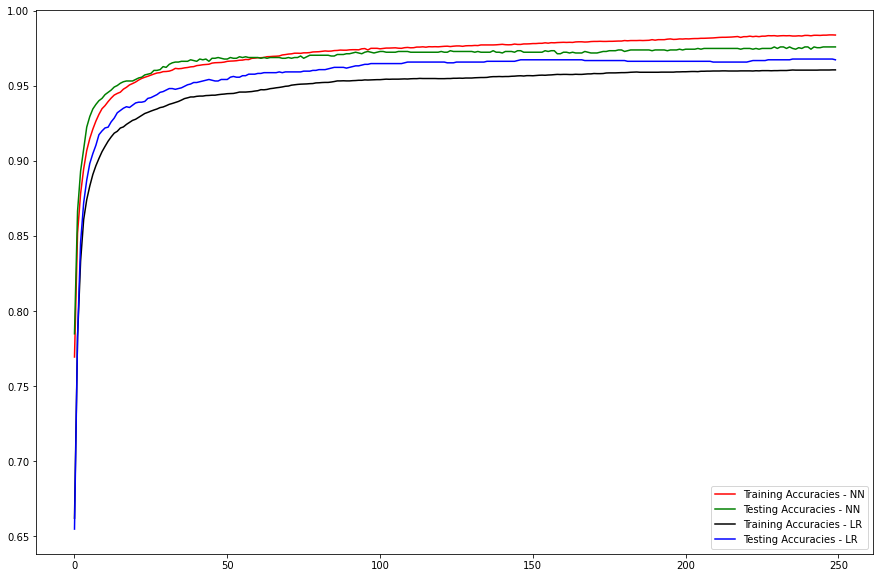

In [24]:
#comparing the results of NN and LR
plt.figure(figsize=(15,10))

# Neural Network plots
plt.plot(acc_nn.accuracies, 'r-', label = "Training Accuracies - NN")
plt.plot(acc_nn.test_accuracies, 'g-', label = "Testing Accuracies - NN")

# Logistic Regression plots
plt.plot(acc_lr.accuracies, 'k-', label = "Training Accuracies - LR")
plt.plot(acc_lr.test_accuracies, 'b-', label = "Testing Accuracies - LR")
plt.legend()

#### Plotting the outputs of this layer of the NN.


In [25]:
new_model = Model(layers[:-2])
testing_plot = new_model(testing_data_x)

Text(0.5, 1.0, 'Outputs')

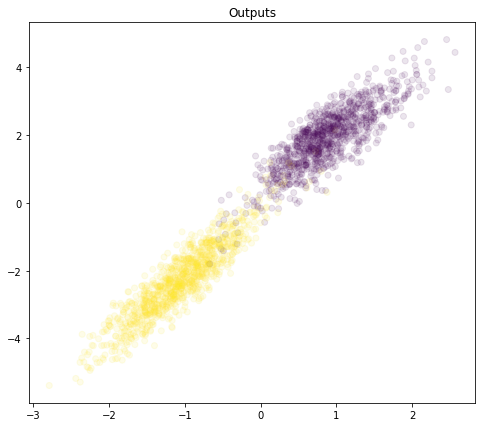

In [26]:
# Plotting the scatter plot of points and color coding by class
plt.figure(figsize=(8,7))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel());
plt.title('Outputs')

Probability contours

In [27]:
model_prob = Model(layers[-2:]) 

In [28]:
#creating the x and y ranges according to the above generated plot.
x_range = np.linspace(-4, 1, 100) 
y_range = np.linspace(-6, 6, 100) 
x_grid, y_grid = np.meshgrid(x_range, y_range) # x_grid and y_grig are of size 100 X 100

# converting x_grid and y_grid to continuous arrays
x_gridflat = np.ravel(x_grid)
y_gridflat = np.ravel(y_grid)

# The last layer of the current model takes two columns as input. Hence transpose of np.vstack() is required.
X = np.vstack((x_gridflat, y_gridflat)).T

prob_contour = model_prob(X).reshape(100,100) 

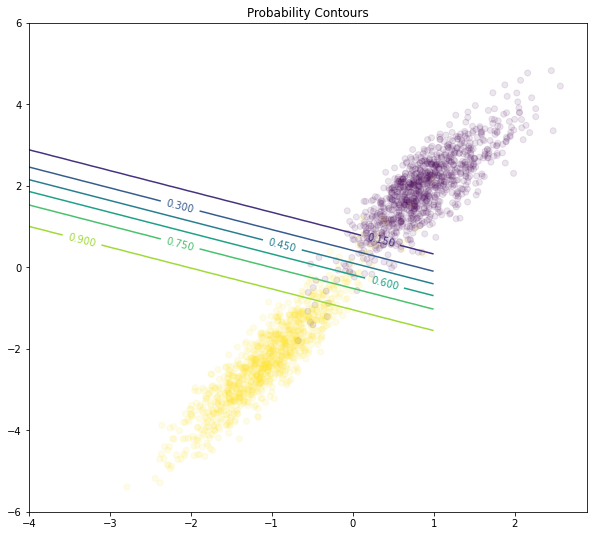

In [29]:
plt.figure(figsize=(10,9))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel())
contours = plt.contour(x_grid,y_grid,prob_contour)
plt.title('Probability Contours')
plt.clabel(contours, inline = True );